<a href="https://colab.research.google.com/github/Sk16er/hope_nano/blob/main/HOPE_Demo_ULTRA_STABLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nano-HOPE: Open source Implementation

**Author:** Shushank  
**Architecture:** Self-Modifying Titans + Continuum Memory

In [ ]:
# @title Installation
!pip install -q tiktoken datasets matplotlib tqdm

In [ ]:
# @title Imports & Setup
import os
import time
import math
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import tiktoken
import matplotlib.pyplot as plt
from tqdm import tqdm
from datasets import load_dataset
from torch.utils.data import DataLoader, IterableDataset
from dataclasses import dataclass
from typing import Optional, Tuple, List

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


In [ ]:
# @title Config
@dataclass
class HOPEConfig:
    vocab_size: int = 50257
    n_embd: int = 384  # Reduced for Colab to 384 if premium use 768
    n_head: int = 6    # coolab free - 6 premium - 12 for better
    n_layer: int = 6   # same 6 or 12
    block_size: int = 256  # Context window - 256/512
    dropout: float = 0.1
    bias: bool = False

config = HOPEConfig()
print(f"Model size: ~{(config.n_layer * config.n_embd**2 * 12) / 1e6:.1f}M parameters")

Model size: ~10.6M parameters


### HOPEModel Definition (Transformer Decoder-only with Continuum Memory) This defines the core architecture, including `MultiHeadAttention`, `FeedForward`, and `Block` modules, composing them into the `HOPEModel`. The `forward` method is designed to accept and return `states` to facilitate "continuum memory" across batches, as implied by the training and generation loops.

In [ ]:
class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch's LayerNorm doesn't support bias=False """
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        # not really a 'bias', but more of a mask, but following the OpenAI/HF naming convention
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                    .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # attention (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias),
            nn.GELU(),
            nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = MultiHeadAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = FeedForward(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

class HOPEModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # initialize all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        print(f"Number of parameters: {self.get_num_params()/1e6:.2f}M")

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count it excludes token embeddings and positional embeddings.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None, states=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)

        new_states = []
        for i, block in enumerate(self.transformer.h):
            if states is not None and states[i] is not None:
                # This is a placeholder for 'continuum memory' / recurrent state
                # A more sophisticated implementation might involve specific fusion mechanisms
                # or modifications to attention/FFN blocks.
                # For now, a simple residual connection from the previous state is used.
                x = x + states[i].to(device) # Ensure state is on the correct device
            x = block(x)
            new_states.append(x) # Store current output as new state

        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss, new_states

# Model Instantiation
model = HOPEModel(config).to(device)
print("✓ HOPEModel instantiated and moved to device.")

Number of parameters: 49.22M
✓ HOPEModel instantiated and moved to device.


In [ ]:
# @title CRITICAL FIX: Compile the model (DISABLED)
# if hasattr(torch, 'compile'):
#     print("Compiling model with torch.compile (6-10x speedup)...")
#     model = torch.compile(model)
#     print("✓ Compilation enabled")
# else:
print("⚠ torch.compile is disabled by user request.")

⚠ torch.compile is disabled by user request.


In [ ]:
# @title Streaming Dataset (Memory Efficient)
class StreamingTextDataset(IterableDataset):
    def __init__(self, split="train", block_size=256): #<-- change to 256 for light use
        self.dataset = load_dataset("roneneldan/TinyStories", split=split, streaming=True)
        self.tokenizer = tiktoken.get_encoding("gpt2")
        self.block_size = block_size

    def __iter__(self):
        buffer = []
        for item in self.dataset:
            tokens = self.tokenizer.encode(item['text'])
            buffer.extend(tokens)
            while len(buffer) >= self.block_size + 1:
                chunk = buffer[:self.block_size + 1]
                buffer = buffer[self.block_size:]
                x = torch.tensor(chunk[:-1], dtype=torch.long)
                y = torch.tensor(chunk[1:], dtype=torch.long)
                yield x, y

train_dataset = StreamingTextDataset(split="train", block_size=config.block_size)
train_loader = DataLoader(train_dataset, batch_size=4)
print("✓ Streaming dataset ready (batch_size=4 for Colab)")

README.md: 0.00B [00:00, ?B/s]

✓ Streaming dataset ready (batch_size=4 for Colab)


Training:   5%|▌         | 502/10000 [00:44<21:24,  7.40it/s, loss=9.0083, lr=9.98e-05] 


[Step 500] Memory reset - CUDA cache cleared


Training:  10%|█         | 1002/10000 [01:26<20:11,  7.43it/s, loss=5.9941, lr=9.88e-05]


[Step 1000] Memory reset - CUDA cache cleared


Training:  15%|█▌        | 1502/10000 [02:09<19:13,  7.37it/s, loss=5.9176, lr=9.70e-05]


[Step 1500] Memory reset - CUDA cache cleared


Training:  20%|██        | 2002/10000 [02:53<18:09,  7.34it/s, loss=5.9996, lr=9.43e-05]


[Step 2000] Memory reset - CUDA cache cleared


Training:  25%|██▌       | 2502/10000 [03:37<18:45,  6.66it/s, loss=6.1716, lr=9.09e-05]


[Step 2500] Memory reset - CUDA cache cleared


Training:  30%|███       | 3002/10000 [04:21<16:16,  7.17it/s, loss=6.3700, lr=8.68e-05]


[Step 3000] Memory reset - CUDA cache cleared


Training:  35%|███▌      | 3502/10000 [05:06<14:59,  7.23it/s, loss=5.9488, lr=8.22e-05]


[Step 3500] Memory reset - CUDA cache cleared


Training:  40%|████      | 4002/10000 [05:51<32:12,  3.10it/s, loss=5.9636, lr=7.71e-05]


[Step 4000] Memory reset - CUDA cache cleared


Training:  45%|████▌     | 4502/10000 [06:36<12:15,  7.47it/s, loss=6.0345, lr=7.17e-05]


[Step 4500] Memory reset - CUDA cache cleared


Training:  50%|█████     | 5002/10000 [07:21<11:25,  7.29it/s, loss=6.0034, lr=6.61e-05]


[Step 5000] Memory reset - CUDA cache cleared


Training:  55%|█████▌    | 5502/10000 [08:05<10:18,  7.27it/s, loss=5.9128, lr=6.05e-05]


[Step 5500] Memory reset - CUDA cache cleared


Training:  60%|██████    | 6002/10000 [08:50<09:00,  7.40it/s, loss=5.9382, lr=5.50e-05]


[Step 6000] Memory reset - CUDA cache cleared


Training:  65%|██████▌   | 6502/10000 [09:34<08:16,  7.04it/s, loss=5.6688, lr=4.98e-05]


[Step 6500] Memory reset - CUDA cache cleared


Training:  70%|███████   | 7002/10000 [10:19<06:42,  7.46it/s, loss=5.9355, lr=4.50e-05]


[Step 7000] Memory reset - CUDA cache cleared


Training:  75%|███████▌  | 7502/10000 [11:03<06:13,  6.69it/s, loss=5.9117, lr=4.06e-05]


[Step 7500] Memory reset - CUDA cache cleared


Training:  80%|████████  | 8002/10000 [11:48<04:34,  7.27it/s, loss=6.6987, lr=3.69e-05]


[Step 8000] Memory reset - CUDA cache cleared


Training:  85%|████████▌ | 8502/10000 [12:33<03:25,  7.30it/s, loss=5.9258, lr=3.40e-05]


[Step 8500] Memory reset - CUDA cache cleared


Training:  90%|█████████ | 9002/10000 [13:17<02:32,  6.55it/s, loss=5.8593, lr=3.18e-05]


[Step 9000] Memory reset - CUDA cache cleared


Training:  95%|█████████▌| 9502/10000 [14:02<01:08,  7.27it/s, loss=6.0392, lr=3.04e-05]


[Step 9500] Memory reset - CUDA cache cleared


Training: 100%|██████████| 10000/10000 [14:46<00:00, 11.28it/s, loss=6.3104, lr=3.00e-05]



✓ Training complete!


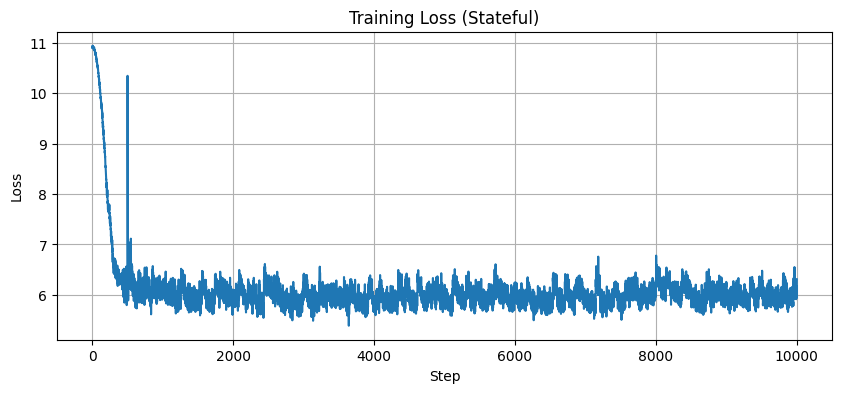

In [ ]:
# @title Training Loop (STATEFUL + AMP)
# from torch.cuda.amp import autocast, GradScaler  # Disabled

# Hyperparameters
max_iters = 10000 #<-- if increassed better training but took more time
learning_rate = 1e-4 #<-- don't set too high learning rate i did and get error.
min_lr = 3e-5
warmup_iters = 200
grad_clip = 1.0

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1)
# scaler = GradScaler()  # Disabled

def get_lr(it):
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    if it > max_iters:
        return min_lr
    decay_ratio = (it - warmup_iters) / (max_iters - warmup_iters)
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (learning_rate - min_lr)

# CRITICAL FIX: Persistent states
persistent_states = None
loss_history = []

model.train()
train_iter = iter(train_loader)
pbar = tqdm(range(max_iters), desc="Training")

for step in pbar:
    lr = get_lr(step)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    try:
        X, Y = next(train_iter)
    except StopIteration:
        train_iter = iter(train_loader)
        X, Y = next(train_iter)

    X, Y = X.to(device), Y.to(device)

    # CRITICAL FIX: Detach states BEFORE forward pass to prevent graph accumulation
    if persistent_states is not None:
        persistent_states = [s.detach().clone() if s is not None else None for s in persistent_states]


    # CRITICAL FIX: Pass states across batches
    # CRITICAL FIX: Autocast disabled to prevent freeze
    # with autocast():
    #     logits, loss, new_states = model(X, Y, states=persistent_states)

    # Direct forward pass (no autocast)
    logits, loss, new_states = model(X, Y, states=persistent_states)

    # Detach states to prevent backprop through time explosion
    persistent_states = [s.detach() if s is not None else None for s in new_states]

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    optimizer.step()

    loss_history.append(loss.item())
    pbar.set_postfix({'loss': f'{loss.item():.4f}', 'lr': f'{lr:.2e}'})

    # CRITICAL FIX: Periodic memory cleanup
    if step % 100 == 0:
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()

    # Reset states periodically to prevent drift
    if step % 500 == 0 and step > 0:
        persistent_states = None
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
        print(f"\n[Step {step}] Memory reset - CUDA cache cleared")

print("\n✓ Training complete!")
plt.figure(figsize=(10, 4))
plt.plot(loss_history)
plt.title("Training Loss (Stateful)")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [ ]:
# @title CRITICAL FIX: True Stateful Generation
@torch.no_grad()
def generate_stateful(model, prompt, max_tokens=200, temperature=0.8):
    model.eval()
    tokenizer = tiktoken.get_encoding("gpt2")
    tokens = torch.tensor(tokenizer.encode(prompt), dtype=torch.long, device=device).unsqueeze(0)

    # Prefill: process prompt once
    logits, _, states = model(tokens)
    next_token = torch.multinomial(F.softmax(logits[0, -1] / temperature, dim=-1), 1)
    tokens = torch.cat([tokens, next_token.unsqueeze(0)], dim=1)

    # Generation: O(1) per token
    for _ in range(max_tokens - 1):
        logits, _, states = model(next_token.unsqueeze(0), states=states)
        next_token = torch.multinomial(F.softmax(logits[0, -1] / temperature, dim=-1), 1)
        tokens = torch.cat([tokens, next_token.unsqueeze(0)], dim=1)

    return tokenizer.decode(tokens[0].tolist())

prompt = "Once upon a time,"
print("Prompt:", prompt)
print("\n" + "="*60)
print(generate_stateful(model, prompt, max_tokens=150))
print("="*60)

Prompt: Once upon a time, 

Once upon a time, !" He slide was so nice his he her. too and a. home a
, to.. bringing You it true She find listen hug
 went the a to It time was He it

 everyone bark and that to close asked bread quite much it a bird to! upon He day, was with. started little It, was up a he mom He,
 in the again,.! was by. twins not the
 the Lily Ben smiled him door,... park a in noise,
 and upon He, please " with,. to play a jumped a to be fun looked itWhen. the voice and. was sheAfter is.. was you., to she, the was, was put. even happy
